# Reproducing **[Jalko et al., 2017]**

Aim is to reproduce the first figures from this plot.

In [1]:
import os 
import sys

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts

In [2]:
# plotting
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

abalone_plot_one_config = {
    "experiment_tag": "reproduce_abalone_plot_one_updated"
}

adult_plot_one_config = {
    "experiment_tag": "reproduce_adult_plot_one"
}

adult_plot_one_np_config = {
    "experiment_tag": "reproduce_adult_np"
}

abalone_plot_one_np_config = {
    "experiment_tag": "reproduce_abalone_np_new"
}

In [3]:
a = SacredExperimentAccess(database_name="sacred")

def aggregate_experiment_results(a, full_exps, non_private):
    acc_metrics = a.get_metrics_by_exp(full_exps, ["test_accuracy", "client_0.MomentAccountant.epsilon"])
    configs = get_dicts_key_subset([exp["config"] for exp in full_exps], ["privacy_settings", "prediction", "seed"])
    collated_exp_info = list(zip(full_exps, acc_metrics, configs))

    aggregated_exp_results = get_unique_dicts(get_dicts_key_subset([exp["config"] for exp in full_exps], ["privacy_settings", "prediction"]))
    aggregated_exp_results = [defaultdict(list, cfg=x) for x in aggregated_exp_results]
    
    for exp, metrics, cfg in collated_exp_info:
        nr_cfg = dict(cfg)
        seed = nr_cfg.pop("seed")
        interval = cfg["prediction"]["interval"]
        ave_test_acc = np.mean(metrics[0]["values"][-interval:])
        eps = metrics[1]["values"][-1]
        exp = next(x for x in aggregated_exp_results if x["cfg"] == nr_cfg)
        exp["eps"].append(eps)
        exp["test_acc"].append(ave_test_acc)  
    
    np_acc_metrics = a.get_metrics_by_exp(non_private[0], "test_accuracy")
    interval = non_private[0]["config"]["prediction"]["interval"]
    np_acc = np.mean(np_acc_metrics[0]["values"][-interval:])
    
    return np_acc, aggregated_exp_results

def plot_experiment_results(np_acc, agg_results, title="Abalone"):
    eps_vals = []
    acc_vals = []
    acc_err_vals = []

    for exp in agg_results:
        eps = np.mean(exp["eps"])
        mean_acc = np.mean(exp["test_acc"])
        std_acc = np.std(exp["test_acc"])
        acc_vals.append(mean_acc)
        acc_err_vals.append(std_acc)
        eps_vals.append(eps)

    eps_vals = np.array(eps_vals)
    acc_vals = np.array(acc_vals)
    acc_err_vals = np.array(acc_err_vals)
    
    plt.figure(figsize=(10, 6))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    indx = np.argsort(eps_vals)

    plt.errorbar(eps_vals[indx], acc_vals[indx], acc_err_vals[indx])
    plt.axhline(np_acc, linestyle="--", color="C1")

    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlabel("$\epsilon$")
    plt.ylabel("Test Accuracy")
    plt.title(title)
    plt.show()

In [4]:
abalone_exps = a.get_experiments(name="jalko2017", complete=True, config=abalone_plot_one_config)
abalone_np = a.get_experiments(name="jalko2017", complete=True, config=abalone_plot_one_np_config)

np_abalone_acc, aggregated_abalone_results = aggregate_experiment_results(a, abalone_exps, abalone_np)

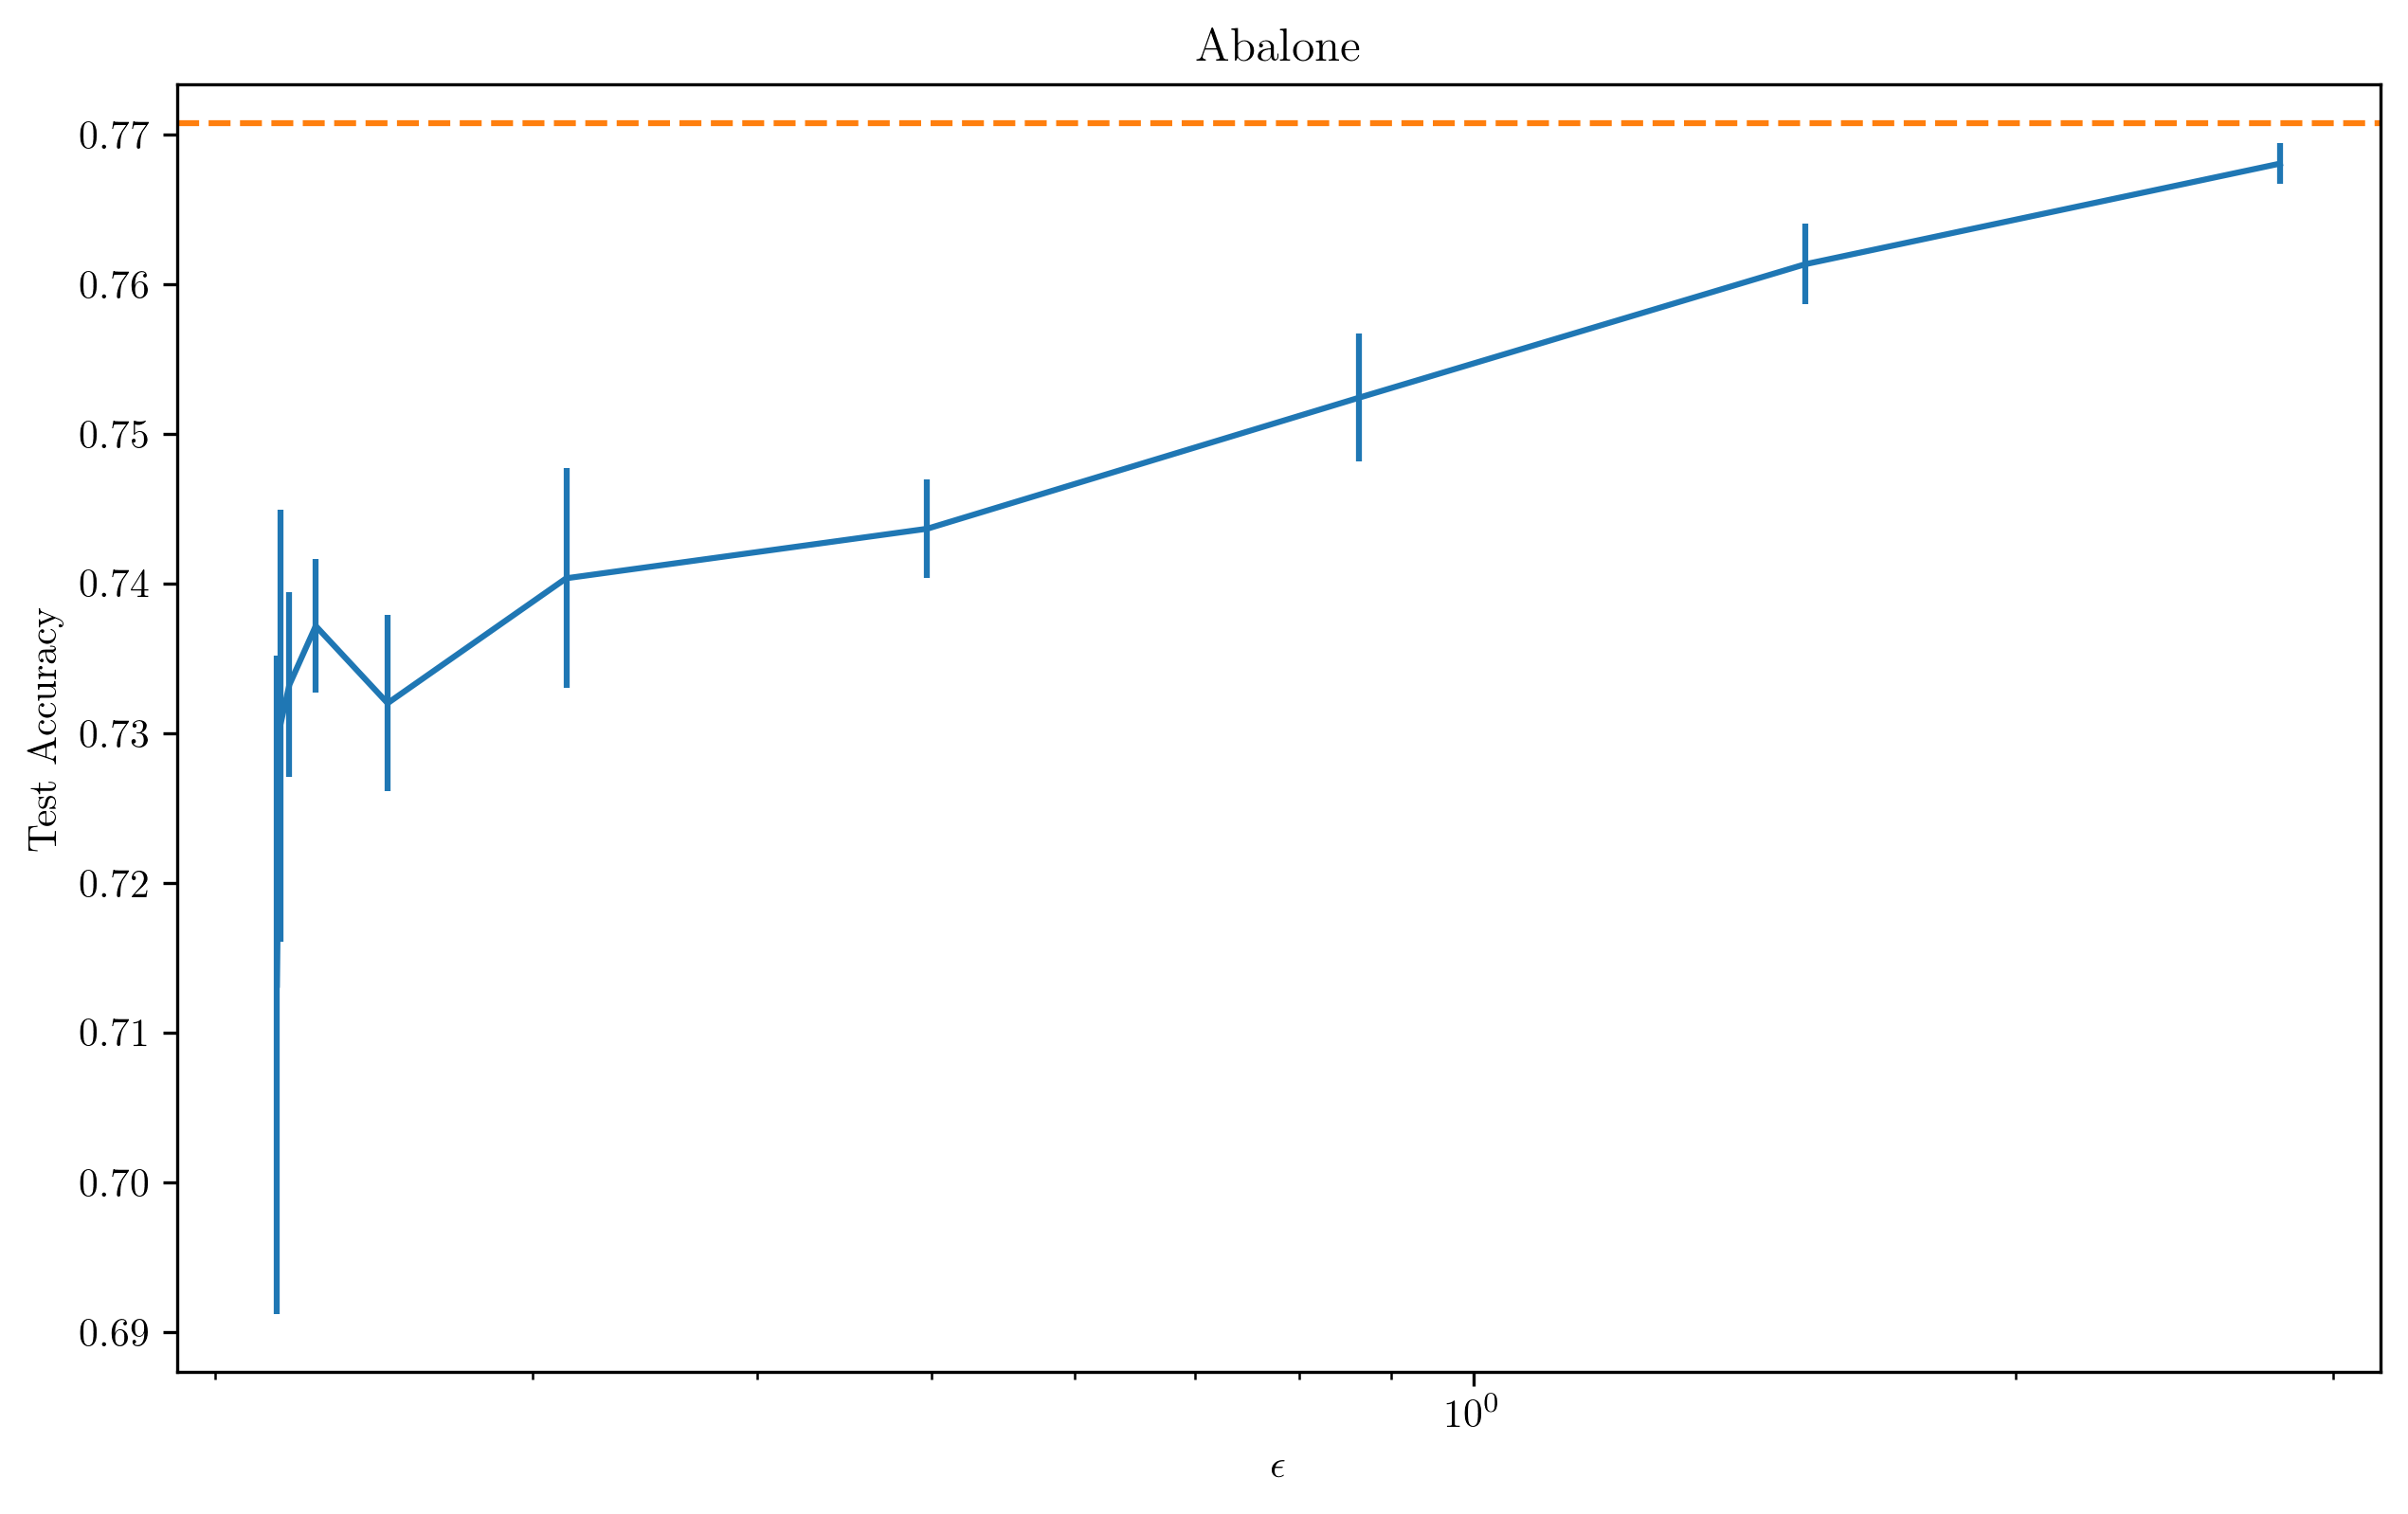

In [5]:
plot_experiment_results(np_abalone_acc, aggregated_abalone_results)

This matches up reasonably well.

In [6]:
adult_exps = a.get_experiments(name="jalko2017", complete=True, config=adult_plot_one_config)
adult_np = a.get_experiments(name="jalko2017", complete=True, config=adult_plot_one_np_config)

In [7]:
np_adult_acc, aggregated_adult_results = aggregate_experiment_results(a, adult_exps, adult_np)
plot_experiment_results(np_adult_acc, aggregated_adult_results, "Adult")

IndexError: list index out of range